#DSCI 619: Deep Learning
## Project 3
Symphony Hopkins

## Introduction

We are a data scientist in ClimateChange company. We were given the Beijing Multi-Site Air Quality Datasets.

Each dataset contains the following features:
* No: row number
* date: date of the observation in the format of year-month-day
* hour: hour of data in this row
* PM10: PM10 concentration (ug/m^3)
* SO2: SO2 concentration (ug/m^3)
* NO2: NO2 concentration (ug/m^3)
* CO: CO concentration (ug/m^3)
* O3: O3 concentration (ug/m^3)
* TEMP: temperature (degree Celsius)
* PRES: pressure (hPa)
* DEWP: dew point temperature (degree Celsius)
* RAIN: precipitation (mm)
* PM2.5: PM2.5 concentration (ug/m^3)
* WSPM: wind speed (m/s)

Each dataset only contains one target:
* wd: wind direction

Our objective is to create an optimal deep learning classification model with specific hyperparameters that can help us forecast the wind direction.

Data Source: [Beijing Multi-Site Air-Quality Data Data Set](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data)



## Data Preparation

**1.Load the dataset, PRSA_Data.csv, into memory.**

First, we will import the necessary libraries to load the dataset.

In [1]:
#connecting to google drive
from google.colab import drive 
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
#importing libraries
import pandas as pd
import os
import glob

There are 12 sites in Beijing, each with their own dataset in the PRSA_Data folder. Because of this, we need to load each dataset and then combine them into a single dataframe.

In [3]:
# use glob to retrieve all 12 csv files in PRSA_Data Folder
path = os.getcwd()
csv_files = glob.glob(os.path.join('gdrive/My Drive/Colab Notebooks/Topic 2/PRSA_Data','*.csv'))
  
  
# reading the csv files into dataframes and concatenating them into a single dataframe
df = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index=True)

#displaying df
display(df.head())

#checking dataframe information
print(f'''
Dataframe Shape: {df.shape}
Number of Sites: {len(df['station'].unique())}
Site Names: {df['station'].unique()}''')

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin



Dataframe Shape: (420768, 18)
Number of Sites: 12
Site Names: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']


**2.Clean and check missing values for this dataset.**

Now that we have created a dataframe, let's clean and check it for missing values.

In [5]:
#checking for missing values
df.isnull().sum(axis = 0)

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

Our target variable, *wd*, contains null values. Since we are creating a model to forecast wind direction, we will not impute the missing values. Instead, we will delete them.

In [4]:
#deleting rows with missing wd values
df.dropna(axis=0, subset = ['wd'], inplace = True)

Let's check if it worked.

In [7]:
#checking for missing values
df.isnull().sum(axis = 0)

No             0
year           0
month          0
day            0
hour           0
PM2.5       8714
PM10        6425
SO2         9000
NO2        12090
CO         20661
O3         13215
TEMP          81
PRES          74
DEWP          84
RAIN          78
wd             0
WSPM           0
station        0
dtype: int64

Now, we will use Multiple Imputation by Chained Reaction (MICE) to deal with the missing values in the other columns. Before we do this, let's make all of the variables numerical.

In [8]:
#checking data types
df.dtypes

No           int64
year         int64
month        int64
day          int64
hour         int64
PM2.5      float64
PM10       float64
SO2        float64
NO2        float64
CO         float64
O3         float64
TEMP       float64
PRES       float64
DEWP       float64
RAIN       float64
wd          object
WSPM       float64
station     object
dtype: object

As we can see, columns *wd* and *station* are not numerical values. We want all data columns to be numerical because...
* Deep learning models only work with numerical values.
* We need numerical values to perform imputation.

For these reasons, we will convert all categorical columns to numerical columns. We will start by converting the *wd* column using label encoding. We are using this method because there are 16 possible cases for wind direction and it will be easier to read the labels when they are represented as a single integer versus a list of integers as seen in one-hot encoding:
* Label Encoding: NNW is represented by '6'
* One-hot Encoding: NNW is represented by [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0] 

In [5]:
#importing libray
import numpy as np

#finding total unique values in wd
tot_wd_unique = len(df['wd'].unique())
print(f'Number of Wind Directions (wd): {tot_wd_unique}')

#sorting unique values in alphabetical order so we know which number corresponds with each label
wd_values = np.sort(df['wd'].unique())

#converting wd to category data types
df['wd'] = df['wd'].astype('category')

#encoding labels
df['wd'] = df['wd'].cat.codes

#checking labels
for i in range(len(wd_values)):
  print(wd_values[i] + ':', np.sort(df['wd'].unique())[i])



Number of Wind Directions (wd): 16
E: 0
ENE: 1
ESE: 2
N: 3
NE: 4
NNE: 5
NNW: 6
NW: 7
S: 8
SE: 9
SSE: 10
SSW: 11
SW: 12
W: 13
WNW: 14
WSW: 15


The *wd* column was successfully converted to numerical values, and we also know which wind direction corresponds with each number. Instead of using label encoding like before, we will use one-hot encoding to convert the *station* column to numerical values using one hot encoding because we do not want the model to assume the data is ordered.

Source: [Choosing the Right Encoding Method-Label vs OneHot Encoder](https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b)

In [6]:
#converting station to numerical values
cat_features = ['station']
factors = pd.get_dummies(df[cat_features],drop_first=True)

#concatenating converted values to dataframe
df = df.drop(cat_features,axis=1)
df = pd.concat([df,factors],axis=1)
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,station_Dingling,station_Dongsi,station_Guanyuan,station_Gucheng,station_Huairou,station_Nongzhanguan,station_Shunyi,station_Tiantan,station_Wanliu,station_Wanshouxigong
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,...,0,0,0,0,0,0,0,0,0,0
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,...,0,0,0,0,0,0,0,0,0,0
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,...,0,0,0,0,0,0,0,0,0,0


Let's check the dataframe to see if all of the columns are numerical.

In [11]:
df.dtypes

No                         int64
year                       int64
month                      int64
day                        int64
hour                       int64
PM2.5                    float64
PM10                     float64
SO2                      float64
NO2                      float64
CO                       float64
O3                       float64
TEMP                     float64
PRES                     float64
DEWP                     float64
RAIN                     float64
wd                          int8
WSPM                     float64
station_Changping          uint8
station_Dingling           uint8
station_Dongsi             uint8
station_Guanyuan           uint8
station_Gucheng            uint8
station_Huairou            uint8
station_Nongzhanguan       uint8
station_Shunyi             uint8
station_Tiantan            uint8
station_Wanliu             uint8
station_Wanshouxigong      uint8
dtype: object

Now that we have confirmed all of the columns are numerical, we can finally impute the missing values.

In [7]:
#importing libraries
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [8]:
#initializing imputer; we set max_iter=20 so we can reach convergence
mice_imputer = IterativeImputer(max_iter=20)

#imputing values
df.iloc[:, :] = mice_imputer.fit_transform(df)

Let's check to see if the values were imputed.

In [14]:
#checking for missing values; there shouldn't be any missing values
df.isnull().sum(axis = 0)

No                       0
year                     0
month                    0
day                      0
hour                     0
PM2.5                    0
PM10                     0
SO2                      0
NO2                      0
CO                       0
O3                       0
TEMP                     0
PRES                     0
DEWP                     0
RAIN                     0
wd                       0
WSPM                     0
station_Changping        0
station_Dingling         0
station_Dongsi           0
station_Guanyuan         0
station_Gucheng          0
station_Huairou          0
station_Nongzhanguan     0
station_Shunyi           0
station_Tiantan          0
station_Wanliu           0
station_Wanshouxigong    0
dtype: int64

**3.Perform feature engineering on the date feature.**


In [15]:
#checking data types
df.dtypes

No                       float64
year                     float64
month                    float64
day                      float64
hour                     float64
PM2.5                    float64
PM10                     float64
SO2                      float64
NO2                      float64
CO                       float64
O3                       float64
TEMP                     float64
PRES                     float64
DEWP                     float64
RAIN                     float64
wd                       float64
WSPM                     float64
station_Changping        float64
station_Dingling         float64
station_Dongsi           float64
station_Guanyuan         float64
station_Gucheng          float64
station_Huairou          float64
station_Nongzhanguan     float64
station_Shunyi           float64
station_Tiantan          float64
station_Wanliu           float64
station_Wanshouxigong    float64
dtype: object

Because the date columns (*year, month, day, hour*) are already in numeric format, we do not need to perform feature engineering.

**4.Split the data into 80% of training and 20% of the test dataset.**


Now, we will now split the data into training and test datasets with 80% going into the training dataset and 20% going into the test dataset. 



In [9]:
#assigning variables
X = df.drop('wd',axis=1)
y = df['wd']

#splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2021)

**5.Preprocess the data using the normalization method to convert all features into the range of [0,1]**


Next, we will normalize the data to convert all of the featues into the range of [0,1].

In [10]:
#importing library
from sklearn.preprocessing import MinMaxScaler

#creating a scaler so we can transform the data to fit within the range of [0,1]
scaler = MinMaxScaler()

#normalizing the data
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building the Neural Network

**6.Build a neuron network with two hidden layers of 20 and 10 neurons to forecast wd using all other features and TensorFlow. Does it overfit or underfit the data? Please justify your answer.**



After cleaning and preparing the data, we can finally build the neural network with the following layers:
* Input Layer: 50
* First Hidden Layer: 20
* Second Hidden Layer: 10
* Output Layer: 16

We have 16 neurons in the output layer, because this is a multiclass classification problem and we have 16 possible wind directions.


In [11]:
#importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#creating empty model
model = keras.Sequential()

#input layer has 50 neurons
model.add(layers.Dense(50, activation='relu'))

#first hidden layer has 20 neurons
model.add(layers.Dense(20, activation='relu'))

#second hidden layer has 10 neurons
model.add(layers.Dense(10, activation='relu'))

#output layer has 16 neurons since there are 16 possible wind directions
model.add(layers.Dense(units = len(df['wd'].unique()), activation='softmax'))

#configuring the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Now that we have setup the model, we can fit the data. While we fit the data, we will keep the history of the training and validation loss to later determine if the model is under-fitting or over-fitting the data.

In [18]:
%%time
#fixing the seed 
tf.random.set_seed(1)

#fitting the model and saving the the history of the training and validation losses
history = model.fit(x=X_train,y=y_train,batch_size=64,epochs=100,
          validation_data=(X_test,y_test), verbose=0)

CPU times: user 30min 33s, sys: 4min 33s, total: 35min 6s
Wall time: 22min 26s


Next, let's visualize the history of the training and validation losses by creating a lineplot.

In [12]:
#importing library
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [20]:
#converting the history into a dataframe
trainhist = pd.DataFrame(history.history)
#adding epoch column to dataframe
trainhist['epoch'] = history.epoch

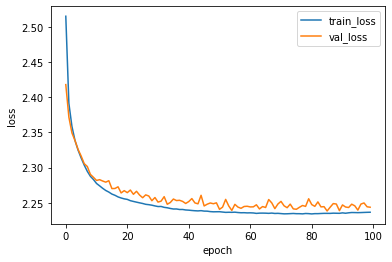

In [21]:
#plotting training loss vs epoch
sns.lineplot(x='epoch', y ='loss', data =trainhist)
#plotting validation loss vs epoch
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])
plt.show()

Overall, both training loss and validation loss are decreasing with a negative slope; however, one could argue that the model is slightly overfitting the data because there is some variation (instability) in the validation loss. 

Let's evaluate the model on the test data. There are multiple ways to evaluate classification models. For this model, we will look at the model summary and then create a confusion matrix.

In [22]:
#displaying model summary
model.evaluate(X_test, y_test, verbose=2)

2619/2619 - 4s - loss: 2.2436 - accuracy: 0.2421 - 4s/epoch - 2ms/step


[2.2436234951019287, 0.2420813888311386]

From the model summary, we can see that the accuracy score is very low (24.21%); however, accuracy can be misleading, so let's look at the confusion matrix.

2619/2619 [==============================] - 4s 1ms/step


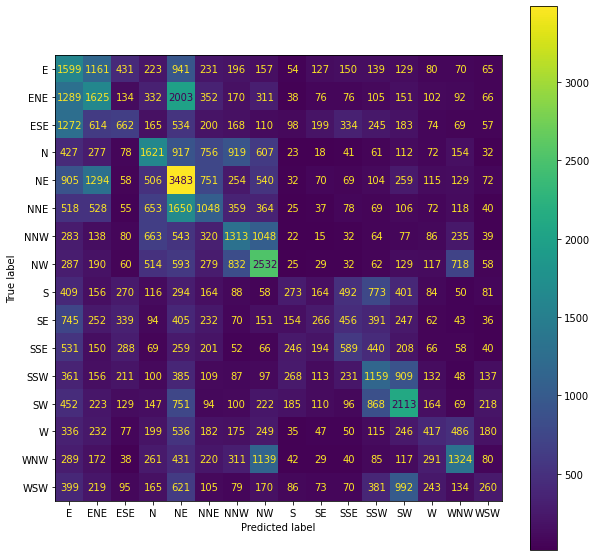

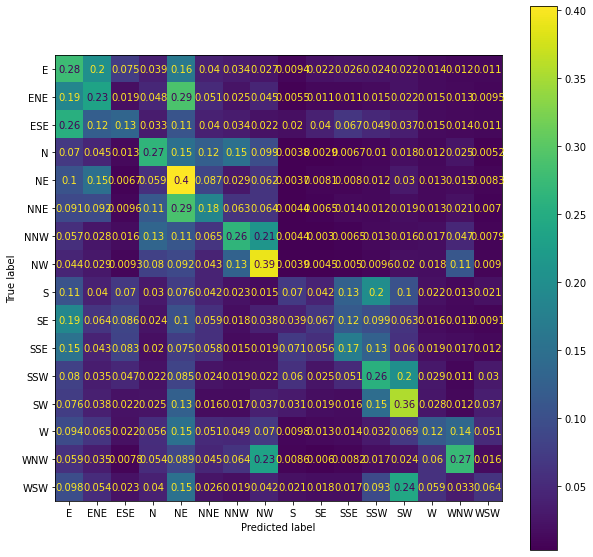

In [23]:
#predicting label based on probability
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#creating confusing matrix
#since we already created a value containing the wind direction names (wd_values), we can just plug it into the following equations
# printing out confusion matrix using count 
cm = confusion_matrix(y_test,classes_x, normalize=None)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=wd_values)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
# printing out confusion matrix using percentage 
cm = confusion_matrix(y_test,classes_x, normalize = 'true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=wd_values)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)


From the results, we can see our model does not accurately forecast the wind directions. Let's see if we can improve this model by tuning the hyperparameters. 

## Hyperparameter Tuning

**7.Tune the model using the following hyperparameters using keras-tuner:**
* **First hidden layer with units between 20 and 100 with a step size of 5**
* **Second hidden layer with units between 10 and 50 with a step size of 2**
* **The dropout rate for both hidden layer is between 0.2 and 0.8 with a step size of 0.1**



We want to create an optimal model. In order to achieve this, we will tune our model using Keras Tuner to find the best hyperparameters. 

In [13]:
#installing keras tuner
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.4 MB/s eta 0:00:00


In [14]:
#importing library
import keras_tuner as kt

In [15]:
%%time
# we need to import Dropout layers from TF
from tensorflow.keras.layers import Dropout
# we may use the constraints for the weights for the optimization algorithms
from tensorflow.keras.constraints import max_norm


#building our model inside of a function 
#the various hyperparameters will be specificed with hp
def model_builder(hp):
  #creating empty model
  model = keras.Sequential()

  #like the model we first created, the input layer will contain 50 neurons
  model.add(layers.Dense(50, activation='relu'))

  #specifying the the minimum value, maximum value, and stepsize for the first hidden layer
  hp_units1 = hp.Int('units_1', min_value = 20, max_value = 100, step = 5)
  #adding first hidden layer
  model.add(layers.Dense(units = hp_units1, activation = 'relu'))
  #specifying the drop out rate for the first hidden layer
  hp_dropout = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.8, step = 0.1)
  #adding dropout layer for the first hidden layer
  model.add(Dropout(rate = hp_dropout))

  #specifying the minimum value, maximum value, and stepsize for the second hidden layer
  hp_units2 = hp.Int('units_2', min_value = 10, max_value = 50, step = 2)
  #adding second hidden layer
  model.add(layers.Dense(units = hp_units2, activation = 'relu'))
  #since the dropout rate for the second hidden layer is the same as the first hidden layer we will use the same variable
  #adding dropout layer for the second hidden layer
  model.add(Dropout(rate = hp_dropout))

  #like the model we first created, the output layer will contain 16 neurons
  model.add(layers.Dense( units = 16, activation='softmax'))

  #configuring the model to specify the optimizer, loss function, and metrics
  model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
  #returning the model
  return model

CPU times: user 257 µs, sys: 0 ns, total: 257 µs
Wall time: 263 µs


Before we can tune the model, we need to instantiate the model first. For this case, we will use Hyperband to instantiate the model. We also want to save the search results, so we will create a new file to store in our directory.

In [16]:
#instantiating the model with Hyperband
tuner = kt.Hyperband(model_builder, 
                     objective = 'val_loss',
                     seed = 1,
                     max_epochs = 100, 
                     directory = 'gdrive/My Drive/Colab Notebooks/Topic 3', 
                     project_name = 'Project3_HopkinsSymphony_TuningRegression')

Because the tuner has many outputs, we will define a callback to clean the outputs at the end of every training step.

In [17]:
#importing library
import IPython
# defining a new parent class for the callback
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  #clearing the output at the end of each training step
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Next, we will perform a search on the defined hyperparameter space.

In [ ]:
#performing search
tuner.search(X_train,
             y_train,
             epochs = 100,
             validation_data = (X_test,y_test),
             callbacks = [ClearTrainingOutput()])


Search: Running Trial #357

Value             |Best Value So Far |Hyperparameter
90                |85                |units_1
0.8               |0.2               |dropout_rate
38                |46                |units_2
100               |4                 |tuner/epochs
0                 |2                 |tuner/initial_epoch
0                 |4                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/100
 4161/10474 [==========>...................] - ETA: 17s - loss: 2.7254 - accuracy: 0.1048

Unfortunately, we had to stop hyperparameter tuning after three days of searching. Even though we had to do an early stop, let's see what the optimal hyperparameters for the model are.

In [19]:
#searching for optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
#printing outputs
print(f"""
Optimal Number of Neurons for First Hidden Layer: {best_hps.get('units_1')}. 
Optimal Number of Neurons for Second Hidden Layer: {best_hps.get('units_2')}. 
Optimal Dropout Rate for First and Second Hidden Layer: {best_hps.get('dropout_rate')}
""")


Optimal Number of Neurons for First Hidden Layer: 85. 
Optimal Number of Neurons for Second Hidden Layer: 46. 
Optimal Dropout Rate for First and Second Hidden Layer: 0.2



Since we know what the optimal hyperparameters are, we will retrain the model using them.

In [27]:
# building the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
#fitting the data
history = model.fit(x=X_train,y=y_train,batch_size=64,epochs=100,
          validation_data=(X_test,y_test), verbose=0)

Next, let's graph the history of the model.

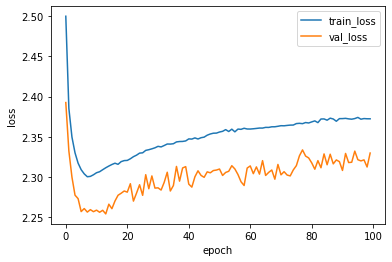

In [28]:
#converting the history into a dataframe
trainhist = pd.DataFrame(history.history)
#adding epoch column to dataframe
trainhist['epoch'] = history.epoch

#plotting training loss vs epoch
sns.lineplot(x='epoch', y ='loss', data =trainhist)
#plotting validation loss vs epoch
sns.lineplot(x='epoch', y ='val_loss', data =trainhist)
#adding legends
plt.legend(labels=['train_loss', 'val_loss'])

With the new hyperparameters, we can see that the model is over-fitting even more than the initial the model. It is important to note that we had to halt hyperparameter tuning early after running the search for three days. If we had let the search continue, we might have found better hyperparameters that did not lead to over-fitting. Let's continue to evaluate the model by looking at the summary.

In [22]:
#displaying model summary
model.evaluate(X_test, y_test, verbose=2)

2619/2619 - 4s - loss: 2.3309 - accuracy: 0.2196 - 4s/epoch - 2ms/step


[2.330885171890259, 0.21959660947322845]

Our current model has an accuracy of 21.96%, which is lower than the initial model (24.21%). However, only looking at accuracy can be misleading so let's create a confusion matrix.

2619/2619 [==============================] - 4s 1ms/step


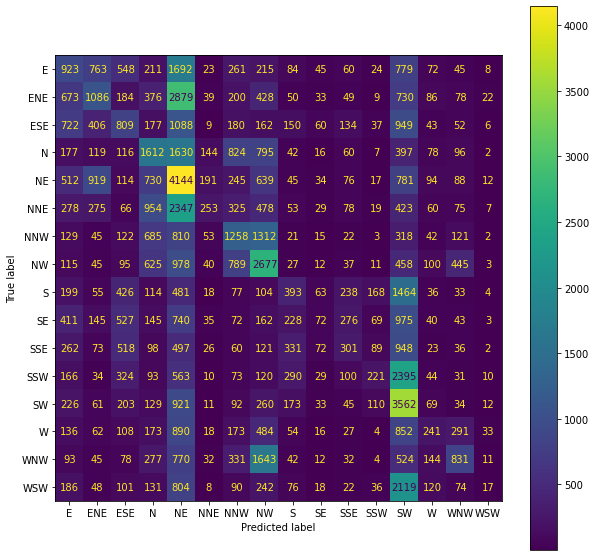

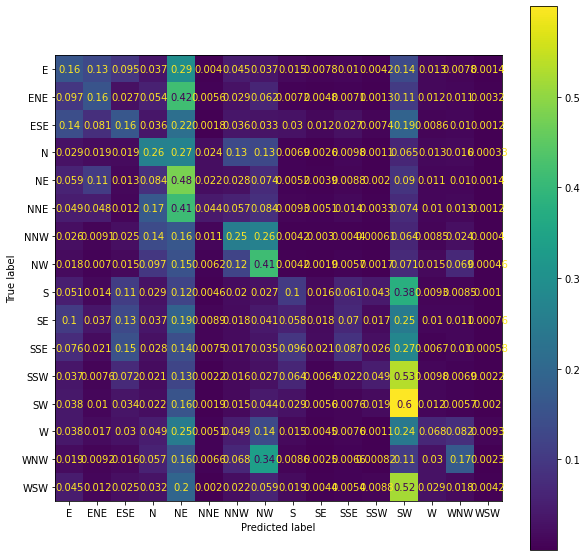

In [23]:
#predicting label based on probability
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

#creating confusing matrix
#since we already created a value containing the wind direction names (wd_values), we can just plug it into the following equations
# printing out confusion matrix using count 
cm = confusion_matrix(y_test,classes_x, normalize=None)
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=wd_values)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
# printing out confusion matrix using percentage 
cm = confusion_matrix(y_test,classes_x, normalize = 'true')
cm_display = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=wd_values)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)

When we compare our new confusion matrix to the initial one, we can see that the percentages are slightly greater for certain wind directions. However, our new model is over-fitting more than the initial model, so that may be the reason why we are seeing higher percentages. Even with this change, the wind direction prediction accuracies for both models are very low.

##Conclusion

We created two deep learning classification models to forecast the wind direction. We found that the best performance came from the first model, which contained the following settings:
* Input Layer: 50
* First Hidden Layer: 20
* Second Hidden Layer: 10
* Output Layer: 16

Even though we performed hyperparameter tuning for the second model, the model's performance did not improve. This may be due to halting the tuning process after three days. If we allowed more time, we might have found better hyperparameters, which would subsequently improve the model's performance. Unfortunately, the model's performance worsened with the second model and we saw more over-fitting of the data. Although we found that the first model performed better, both models had low accuracies when forecasting the wind directions as seen in the confusion matrix. Overall, neither model performs well, however, if we had to recommend a model, then the first model would be the best choice.